# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [22]:
!wget https://github.com/hse-ds/iad-applied-ds/raw/refs/heads/2024/homeworks/hw4_recsys/tracks_info.csv
!wget https://github.com/hse-ds/iad-applied-ds/raw/refs/heads/2024/homeworks/hw4_recsys/music_dataset.csv

--2024-12-27 17:37:52--  https://github.com/hse-ds/iad-applied-ds/raw/refs/heads/2024/homeworks/hw4_recsys/tracks_info.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hse-ds/iad-applied-ds/refs/heads/2024/homeworks/hw4_recsys/tracks_info.csv [following]
--2024-12-27 17:37:54--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/refs/heads/2024/homeworks/hw4_recsys/tracks_info.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3416170 (3.3M) [text/plain]
Saving to: ‘tracks_info.csv.1’

tracks_info.csv.1   100%[===================>]   3.26M  --.-KB/s    in 0.08s   

2024-12-27 17:37:54 (

In [23]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [24]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head(20)

# ratings.groupby('userId').count()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404
5,0,432
6,0,470
7,0,490
8,0,491
9,0,559


In [72]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.tail(20)

,id,name,artists
72363,72363,Круги на воде,['Григорий Лепс']
72364,72364,Всё казалось мило,['Джаро & Ханза']
72365,72365,А мы любили,"['LOVV66', 'ENCORE SQUAD']"
72366,72366,Жизнь идёт,['Сергей Грищук']
72367,72367,Северная страна,"['25/17', 'Oxxxymiron']"
72368,72368,Imago,['КУОК']
72369,72369,Нереальная,['Дмитрий Колдун']
72370,72370,Адепты секты,['XIII']
72371,72371,За всех,['MACAN']
72372,72372,handmade,"['Leftoz', 'Hxsle']"


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [73]:
def relevance(relevant: List[int], predicted: int):
    return int(predicted in relevant)


def pk(relevant: List[int], predicted: List[int]):
    rel_vec = [relevance(relevant, pred) for pred in predicted]

    return sum(rel_vec) / len(rel_vec)


def apk(relevant: List[int], predicted: List[int], k):

    k_pred = predicted[:k]

    apk_acc = 0
    n_rel = 0

    for i in range(len(k_pred)):
        r = relevance(relevant, k_pred[i])
        p = pk(relevant, k_pred[:i+1])

        n_rel += r
        apk_acc += r*p

    return apk_acc / min(len(relevant), k)


def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):

    pairs = zip(relevant, predicted)
    apks = [apk(rel, pred, k) for rel, pred in pairs]

    return sum(apks) / len(apks)

In [74]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]


assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [75]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [76]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [77]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [78]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [79]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [80]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [81]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [82]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [83]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.vectorized_ratings = pd.DataFrame(ratings.groupby('userId')['trackId'].apply(np.array))

        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        # Создаем новый массив `new_preds` размером [n_users, k], заполненный значением по умолчанию (например, -1).
        new_preds = np.full((len(preds), k), -1, dtype=int)

        # Группируем обучающие данные по `userId`.
        for user_id, user_data in self.ratings.groupby('userId'):
            # Извлекаем рекомендации для текущего пользователя.
            user_preds = preds[user_id]

            # Фильтруем рекомендации, исключая те элементы, которые уже есть в обучающих данных.
            filtered_preds = user_preds[~np.in1d(user_preds, user_data['trackId'])]

            # Если отфильтрованных элементов меньше, чем `k`, заполняем оставшиеся места значением по умолчанию.
            if len(filtered_preds) >= k:
                new_preds[user_id] = filtered_preds[:k]
            else:
                new_preds[user_id, :len(filtered_preds)] = filtered_preds

        return new_preds



    def get_test_recommendations(self, k: int):
        test_preds = []

        for uid in tqdm(range(self.n_users)):
            test_preds.append(self.recommend(uid))

        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [37]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:

    all_vectors = pd.DataFrame(ratings.groupby('userId')['trackId'].apply(np.array))
    all_vectors['coincidence'] = all_vectors['trackId'].apply(lambda x: np.isin(user_vector, x).astype(int))
    all_coincidence_vectors = np.stack(all_vectors['coincidence'].values)

    covar = all_coincidence_vectors.sum(axis=1)

    all_tracks_len = np.stack(all_vectors['trackId'].apply(len).values)
    denominator_all = np.sqrt(all_tracks_len)

    denominator_user_vector = np.sqrt(np.sum(np.square(np.ones_like(user_vector))))

    st_dev = denominator_all * denominator_user_vector


    return covar / st_dev


first_user = ratings.groupby('userId')['trackId'].apply(np.array)[0]
z = pearson(ratings, first_user)

In [38]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:

    all_vectors = pd.DataFrame(ratings.groupby('userId')['trackId'].apply(np.array))

    all_vectors['intersection'] = all_vectors['trackId'].apply(lambda x: sum(np.isin(user_vector, x).astype(int)))
    all_intersections = np.stack(all_vectors['intersection'].values)

    all_vectors['len'] = all_vectors['trackId'].apply(len)
    all_vectors['union'] = all_vectors['len'] - all_vectors['intersection'] + len(user_vector)


    return np.array(all_vectors['intersection'] / all_vectors['union'])

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [52]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        выдаёт множество соседей N(u), т.е. набор векторов с айди треков разных пользователей
        и вектор сходств
        """
        sim_vec = self.similarity_func(self.ratings, user_vector)

        N_ids = np.where((sim_vec > self.alpha) & (sim_vec != 1))[0]

        N = pd.DataFrame(self.vectorized_ratings.loc[N_ids, :])
        N['similarity'] = sim_vec[N_ids]

        return N


    def predict_rating(self, track_id: int, N: pd.DataFrame,
                       user_vector: np.array):
        track_to_users = N['trackId'].apply(lambda x: track_id in x)
        relevant_users = N[track_to_users]
        numerator = relevant_users['similarity'].sum()
        return numerator / denominator if denominator != 0 else 0



    def recommend(self, uid: int):

        user_vector = self.vectorized_ratings.loc[uid, 'trackId']
        N = self.similarity(user_vector)

        # Explode the trackId lists into individual rows
        exploded_N = N.explode('trackId')

        # Group by trackId and sum the similarities
        track_similarity_sum = exploded_N.groupby('trackId')['similarity'].sum().reset_index()

        # Filter out tracks already in the user's vector
        tracks = track_similarity_sum[~track_similarity_sum['trackId'].isin(user_vector)]['trackId'].values

        # Calculate the predicted ratings
        total_similarity = N['similarity'].sum()
        ratings = track_similarity_sum[~track_similarity_sum['trackId'].isin(user_vector)]['similarity'].values / total_similarity

        # Sort the tracks based on ratings
        sorted_ids = np.argsort(ratings)[::-1]

        return tracks[sorted_ids]

    def random_recommend(self, uid: int):
        user_vector = self.vectorized_ratings.loc[uid, 'trackId']
        N = self.similarity(user_vector)

        # Explode the trackId lists into individual rows
        exploded_N = N.explode('trackId')

        # Group by trackId and sum the similarities
        track_similarity_sum = exploded_N.groupby('trackId')['similarity'].sum().reset_index()

        # Filter out tracks already in the user's vector
        tracks = track_similarity_sum[~track_similarity_sum['trackId'].isin(user_vector)]['trackId'].values

        return np.random.permutation(tracks)

model = User2User(ratings, pearson)

model.get_test_recommendations(10)

  0%|          | 0/241 [00:00<?, ?it/s]

array([[ 9693,  7533,  3189, ..., 10804,  1073,  9691],
       [24607,  2814, 33677, ..., 69019, 18496, 35338],
       [ 1073, 11502,  1019, ...,  9694,  5872,  6376],
       ...,
       [  805, 18496,  2814, ..., 33677, 69019, 35944],
       [  805,  7533,  4032, ...,  9694,  5521, 24607],
       [33677, 18104,  2814, ...,  8263, 26714, 54223]])

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [40]:
def vectorize_rating(ratings):
    df = pd.DataFrame(ratings.groupby('userId')['trackId'].apply(np.array))
    return df

model_pearson = User2User(train_ratings, pearson)
model_jaccard = User2User(train_ratings, jaccard)


# тут, получается relevant для каждого пользователя
test_ratings_vectorized = vectorize_rating(test_ratings).trackId.tolist()
relevant = [list(element) for element in test_ratings_vectorized][:10]

# делаем предикт и смотрим, какие получаются mapk при разных k

pred_pearson = []
pred_jaccard = []
for uid in tqdm(range(model_pearson.n_users)):
    pred_pearson.append(model_pearson.recommend(uid))
    pred_jaccard.append(model_jaccard.recommend(uid))






  0%|          | 0/241 [00:00<?, ?it/s]

In [41]:
model_pearson = User2User(train_ratings, pearson)

pred_random = []
for uid in tqdm(range(model_pearson.n_users)):
    pred_random.append(model_pearson.random_recommend(uid))


  0%|          | 0/241 [00:00<?, ?it/s]

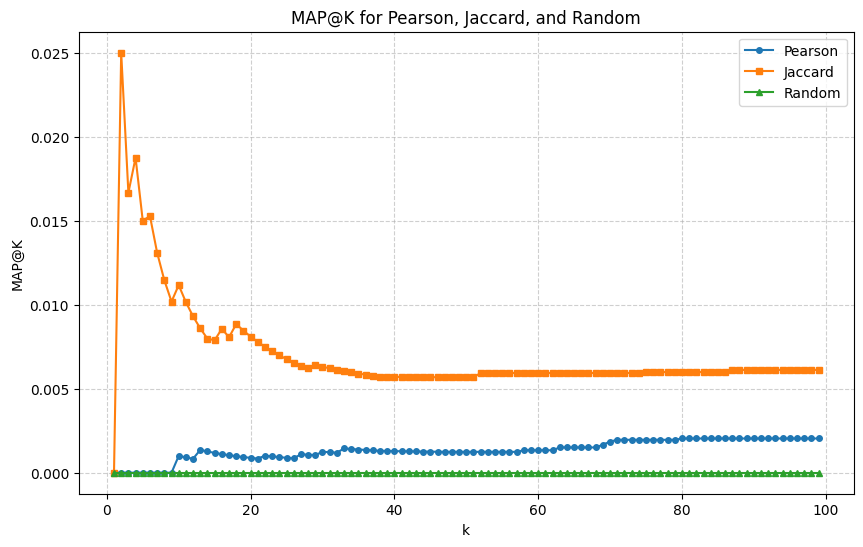

In [42]:
mapk_dict = {'pearson': [],
        'jaccard': [],
        'random': []}
for k in range(1, 100):
  mapk_dict['pearson'].append(mapk(relevant, pred_pearson, k=k))
  mapk_dict['jaccard'].append(mapk(relevant, pred_jaccard, k=k))
  mapk_dict['random'].append(mapk(relevant, pred_random, k=k))


import matplotlib.pyplot as plt

k_values = range(1, 100)

# Plot the line chart
plt.figure(figsize=(10, 6))

plt.plot(k_values, mapk_dict['pearson'], label='Pearson', marker='o', markersize=4)
plt.plot(k_values, mapk_dict['jaccard'], label='Jaccard', marker='s', markersize=4)
plt.plot(k_values, mapk_dict['random'], label='Random', marker='^', markersize=4)

# Add labels and title
plt.xlabel('k')
plt.ylabel('MAP@K')
plt.title('MAP@K for Pearson, Jaccard, and Random')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [94]:
user_id = np.random.randint(0, model.n_users)
user_id

165

In [95]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
11,Long Tall Sally,['Little Richard']
27,La Camisa Negra,['Juanes']
29,Hello,['Lionel Richie']
30,"Say You, Say Me",['Lionel Richie']
46,Stop,"['Sam Brown', 'Pete Brown']"
209,I Got You (I Feel Good),['James Brown']
228,Big Big World,['Emilia']
234,Wind Of Change,['Scorpions']
257,The Lady In Red,['Chris De Burgh']
258,What A Wonderful World,['Louis Armstrong']


In [86]:
preds = model.get_test_recommendations(15)

  0%|          | 0/241 [00:00<?, ?it/s]

In [96]:
print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
9438,Что такое осень,['ДДТ']
11711,A Lovers Complaint,['Max Richter']
5872,Я свободен,['Кипелов']
24040,Imposters (Little by Little),['The Fratellis']
17133,Revolution,"['Diplo', 'ImanoS', 'Faustix', 'Kai']"
1056,Don't Speak,['No Doubt']
805,Zombie,['The Cranberries']
846,Send Me An Angel,['Scorpions']
1019,It's My Life,['Bon Jovi']
234,Wind Of Change,['Scorpions']


In [93]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
47601,Daddy,['Die Antwoord']
48865,Катманду,['Крематорий']
49577,Кукла колдуна,['Король и Шут']
50169,Дерзость и молодость,['F.P.G.']
50362,Холодное,['F.P.G.']
50363,Стремиться,['F.P.G.']
50364,Вальс,['F.P.G.']
51173,Long And Lonesome Road,['Shocking Blue']
51349,Every Breath You Take,['Sting']
51656,Friend Like Me,['Will Smith']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

### LFM (Latent Factor Model with SGD)

**Ответ:**

Функция потерь:
$$
L = \sum_{(i, j) \in \Omega} (R_{ij} - P_i Q_j^T)^2 + \lambda (\|P_i\|^2 + \|Q_j\|^2).
$$

Градиенты:
$$
\frac{\partial L}{\partial P_i} = -2 \sum_{j \in \Omega_i} (R_{ij} - P_i Q_j^T) Q_j + 2 \lambda P_i,
$$
$$
\frac{\partial L}{\partial Q_j} = -2 \sum_{i \in \Omega_j} (R_{ij} - P_i Q_j^T) P_i + 2 \lambda Q_j.
$$

Обновление параметров:
$$
P_i \leftarrow P_i - \eta \frac{\partial L}{\partial P_i},
$$
$$
Q_j \leftarrow Q_j - \eta \frac{\partial L}{\partial Q_j}.
$$

---

### ALS (Alternating Least Squares)

**Ответ:**

Обновление \( P \) при фиксированном \( Q \):
$$
P_i = \left( \sum_{j \in \Omega_i} Q_j Q_j^T + \lambda I \right)^{-1} \sum_{j \in \Omega_i} R_{ij} Q_j.
$$

Обновление \( Q \) при фиксированном \( P \):
$$
Q_j = \left( \sum_{i \in \Omega_j} P_i P_i^T + \lambda I \right)^{-1} \sum_{i \in \Omega_j} R_{ij} P_i.
$$

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639
